# Deep Learning on Graph Data:

In this presentation we use Tensorflow to perform optimizations on a randomly generated input graph. 

In [14]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import itertools as it

In [15]:
# create new session if we need it
sess = tf.Session()

In [39]:
def gen_rand_graph(n=20, p=0.3):
    # Modelling the resource allocation with Normal Distrib - mean: m, and stddev = s
    m = 20
    s = 0.25

    sess.run(tf.global_variables_initializer())
    G_rand = nx.duplication_divergence_graph(n, p, 1)

    # add tf risk constants and variables to each node
    for node, data in G_rand.nodes_iter(data=True):
        data['risk'] = tf.constant(np.random.uniform(0,1))
        data['risk_A'] = np.random.uniform(0,1)
        data['risk_B'] = np.random.uniform(0.5,1.5)
        data['allocation'] = tf.Variable(tf.random_normal([1,1], mean = m, stddev=s))

    # show what we generated
    for node, data in it.islice(G_rand.nodes_iter(data=True),5):
        print 'Node',node,'|', 'Risk of the node:', sess.run(data['risk'])
        #print 'Node data:', data
        #print 'Allocation (Variable of the node):', sess.run(data['allocation'])

    return G_rand

Node 0 | Risk of the node: 0.759288
Node 1 | Risk of the node: 0.902692
Node 2 | Risk of the node: 0.454715
Node 3 | Risk of the node: 0.706294
Node 4 | Risk of the node: 0.327205


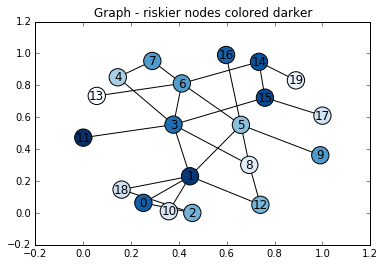

In [40]:
graph = gen_rand_graph()

color_values = [sess.run(data['risk']) for node, data in graph.nodes_iter(data=True)]

pos = nx.spring_layout(graph)
nx.draw_networkx_nodes(graph, pos, cmap=plt.cm.Blues, node_color = color_values)
nx.draw_networkx_edges(graph, pos, arrows=True)
nx.draw_networkx_labels(graph,pos)
plt.title('Graph - riskier nodes colored darker')
plt.show()

In [21]:
def query2(G, alpha=tf.constant(0.0)):
    allocation_sumexp = tf.constant(0.0)
    risk_sum = tf.constant(0.0)
    
    for node, data in G.nodes_iter(data=True):
        allocation_sumexp += tf.exp(data['allocation'])
        risk_sum += data['risk']
    
    cost = tf.constant(0.0)
    
    for i in nx.dfs_preorder_nodes(G, 0):
        node = G.node[i]
        softmax_allocation = tf.exp(node['allocation'])/allocation_sumexp
        normalized_risk = tf.exp(node['risk'])/risk_sum
        node['softmax_allocation'] = softmax_allocation
        cost += normalized_risk*softmax_allocation + alpha*node['softmax_allocation']**2
        
#         print G.neighbors(i)
        for neighbor in G.neighbors(i):
#             print G.node[neighbor]
            cost += 0.25 * G.node[neighbor]['risk'] * softmax_allocation / risk_sum

    return cost

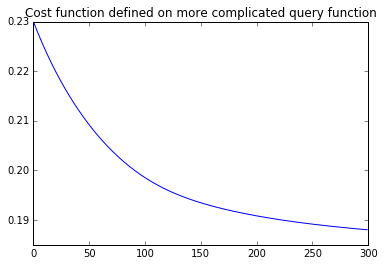

In [25]:
def test_query(graph, query, train_steps=100):
    learning_rate = 1.0
    alpha = tf.constant(0.2)
    cost = query(graph, alpha)
    optimizer = tf.train.AdagradOptimizer(learning_rate)
    train = optimizer.minimize(cost)
    #reinitialise everything
    sess.run(tf.global_variables_initializer())
    #Now optimize with this form
    cost_tracker = np.zeros([train_steps])
    for step in range(train_steps):
        sess.run(train)

        cost_tracker[step] = sess.run(cost)
    plt.plot(cost_tracker)
    plt.title("Cost function defined on more complicated query function")

test_query(graph, query2, train_steps=300)

In [54]:
# Convert graph to tensor form
def convert(G, d):
    x = np.zeros((d,2))
    ind = 0
    for i in nx.dfs_preorder_nodes(G, 0):
        node = G.node[i]
        x[ind,0] = node['risk_A']
        x[ind,1] = node['risk_B']
        ind += 1
    
    return x
    

x = convert(graph, 20)

#reinitialise everything
sess.run(tf.global_variables_initializer())

# Construct query
# tf Graph Input
X = tf.placeholder("float", shape=(20,2))

# Set model weights
w = tf.Variable(tf.random_normal([1,2]), name="weight")

alpha = tf.constant(0.2)

alloc = tf.exp(w) / tf.reduce_sum(tf.exp(w))
cost = tf.reduce_sum(tf.multiply(alloc, X)) + alpha*tf.matmul(tf.transpose(w),w)

optimizer = tf.train.AdagradOptimizer(0.1)
trainer = optimizer.minimize(cost)

sess.run(trainer, feed_dict={X : x})
print sess.run(w)

FailedPreconditionError: Attempting to use uninitialized value weight_10
	 [[Node: weight_10/read = Identity[T=DT_FLOAT, _class=["loc:@weight_10"], _device="/job:localhost/replica:0/task:0/cpu:0"](weight_10)]]

Caused by op u'weight_10/read', defined at:
  File "/usr/local/Cellar/python/2.7.12/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/local/Cellar/python/2.7.12/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-54-e93e9c4e4ca3>", line 24, in <module>
    w = tf.Variable(tf.random_normal([1,2]), name="weight")
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/ops/variables.py", line 226, in __init__
    expected_shape=expected_shape)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/ops/variables.py", line 344, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1490, in identity
    result = _op_def_lib.apply_op("Identity", input=input, name=name)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2395, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1264, in __init__
    self._traceback = _extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value weight_10
	 [[Node: weight_10/read = Identity[T=DT_FLOAT, _class=["loc:@weight_10"], _device="/job:localhost/replica:0/task:0/cpu:0"](weight_10)]]
